<a href="https://colab.research.google.com/github/larax2do/RE-MPMGA/blob/main/PFC1_MPMGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Re] Multi-population migration genetic algorithm MPMGA

Trabajo realizado para el curso de Proyecto Final de Carrera I de la carrera de Ciencia de la computacion de la Universidad Nacion de San Agustin de Arequipa

Asesora: Dra Jeaneth Machicao

## Librerias

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import statistics
import datetime

## Cromosoma

In [171]:
class Cromosoma:
  def __init__(self,g,f):
    self.genes=g
    self.fitnes=f

### Funciones de ayuda 

In [172]:
def numero_de(x,y,N):
  return ((x)+(y)*N)
def cordenada_de(p,N):
  return ((p%N)),int(np.floor(p/N))

## Funcion de Optimizacion

In [173]:
def fitness1(entrada,dim):
  path=0
  for i in range(len(entrada)-1):
    x1,y1=cordenada_de(entrada[i],dim[0])
    #print("x1",x1)
    #print("y1",y1)
    x2,y2=cordenada_de(entrada[i+1],dim[0])
    #print("x2",x2)
    #print("y2",y2)
    #print("agregado:",math.sqrt(((x2-x1)**2)+((y2-y1)**2)))
    path+=math.sqrt(((x2-x1)**2)+((y2-y1)**2))
  #print("print final: ",path)
  return 1/path

def fitness2(entrada,dim):
  smoothness=0
  for i in range(1,len(entrada)-1):
    x0,y0=cordenada_de(entrada[i-1],dim[0])
    x1,y1=cordenada_de(entrada[i],dim[0])
    x2,y2=cordenada_de(entrada[i+1],dim[0])
    k1=((y1-y0)/(x1-x0)) if x1!=x0 else "INFINITO" 
    k2=((y2-y1)/(x2-x1)) if x2!=x1 else "INFINITO" 
    if not ((k1=="INFINITO" and k2=="INFINITO") or  (k1==k2 and k1!="INFINITO" and k2!="INFINITO")):
      a1=((x0-x1)**2)+((y0-y1)**2)
      b1=((x2-x1)**2)+((y2-y1)**2)
      c1=((x0-x2)**2)+((y0-y2)**2)
      a=math.sqrt(a1)
      b=math.sqrt(b1)
      c=math.sqrt(c1)
      di=(a1+b1-c1)/(2*a*b)
      alpha_i=math.acos(di)
      tetha_i=math.pi-alpha_i
      smoothness+=0 if tetha_i==0 else 5 if 0<tetha_i and tetha_i<math.pi/2 else 25 if tetha_i==math.pi/2 else 125 if tetha_i>math.pi/2 else 0
  return 1/smoothness

def fitness(entrada,a,b,dim):
  return a*fitness1(entrada,dim)+b*fitness2(entrada,dim)

def fitness_detallado(entrada,a,b,dim):
  f1=fitness1(entrada,dim)
  f2=fitness2(entrada,dim)
  print("Path: ",f1**-1)
  print("Smoothness: ",f2**-1)
  print("fitnes Total: ",a*fitness1(entrada,dim)+b*fitness2(entrada,dim))
  

## Generacion de Poblacion Inicial

In [174]:
# Retorna valores de cuadricula de las cuadriculas colindantes
def adyacentes(a,dim):
  add=[a-1,a+1,a+dim[0],a-dim[0],a+dim[0]+1,a+dim[0]-1,a-dim[0]+1,a-dim[0]-1]
  return [i  for i in add if (i>-1 and i<numero_de(dim[0],dim[1],dim[0])+1)and(i%dim[0]==(a%dim[0])+1 or i%dim[0]==(a%dim[0])-1 or i%dim[0]==(a%dim[0]))]

# Verifica si dos cuadriculas son colindantes
def verificacion(a,b,dim):
  if a in adyacentes(b,dim):
    return True
  return False

# Calcula el punto medio entre dos cuadriculas
def valor_medio(entrada,dim):
  x1,y1=cordenada_de(entrada[0],dim[0])

  x2,y2=cordenada_de(entrada[1],dim[0])

  return numero_de((x1+x2)//2,(y1+y2)//2,dim[0])

# Operador de Conexion
def conexion(map,entrada,dim):
  #print("conexion de: ",entrada)
  if verificacion(entrada[0],entrada[1],dim):#sospechoso
    return entrada
  else:
    intermedio=valor_medio(entrada,dim)
    while intermedio in map or (intermedio==entrada[0] or intermedio==entrada[1]):
      vecinos=[ i for i in adyacentes(intermedio,dim) if i not in map]
      if len(vecinos) ==0:
        vecinos=adyacentes(intermedio,dim)
      intermedio=random.choice(vecinos)
    parte1=conexion(map,[entrada[0],intermedio],dim)
    parte2=conexion(map,[intermedio,entrada[1]],dim)
    return parte1+parte2

# Operador de Eliminacion, quita los caminos circulares
def quitar_caminos_circulares(entrada):
  pila=[]
  for i in entrada:
    if i not in pila:
      pila.append(i)
    else:
      while(i in pila):
        pila.pop()
      pila.append(i)
  return pila

def crearCISB(map,ini,dim):
  #print(abs(cordenada_de(ini[0],dim[0])[0]-cordenada_de(ini[1],dim[0])[0]))
  cisb=[ini[0]]
  for _ in range(3):
    tempx=random.randint(0,dim[0]-1)
    tempy=random.randint(0,dim[1]-1)
    temp=numero_de(tempx,tempy,dim[0])
    while temp in map:
      tempx=random.randint(0,dim[0]-1)
      tempy=random.randint(0,dim[1]-1)
      temp=numero_de(tempx,tempy,dim[0])
    cisb.append(temp)
  cisb.append(ini[1])
  return cisb

# Crea un cromosoma, con una solucion
def crear_individuo(map,ini,dim,a,b):
  inicial=crearCISB(map,ini,dim)
  #print("inicial",inicial)
  conexo=[]
  for i in range(0,len(inicial)-1):
    conexo=conexo+conexion(map,[inicial[i],inicial[i+1]],dim)
  #conexo=conexion(map,ini,dim)
  limpio=quitar_caminos_circulares(conexo)
  fit=fitness(limpio,a,b,dim)
  return Cromosoma(limpio,fit)

## Graficador

In [175]:
def plotear(mapa,camino,dim):
  xs=[]
  ys=[]
  for i in range(-1,dim[0]+1):
    xs.append(i)
    ys.append(-1)
  for i in range(-1,dim[0]+1):
    xs.append(i)
    ys.append(dim[1])
  for i in range(-1,dim[1]+1):
    xs.append(-1)
    ys.append(i)
  for i in range(-1,dim[1]+1):
    xs.append(dim[1])
    ys.append(i)
  plt.grid(True)
  plt.axis("equal")
  plt.plot(xs,ys,"sk",markersize=6)
  for i in mapa:
    x,y=cordenada_de(i,dim[0])
    plt.plot(x,y,"sk",markersize=6)
  cmapa=[]
  for i in camino:
    cmapa.append(cordenada_de(i,dim[0]))
  test=list(zip(*cmapa))
  print(test)
  plt.plot(test[0],test[1])
  plt.show()

## Operadores AG

### Seleccion Ruleta

In [176]:
def crearRuleta(populacho):

  acumulada=[f.fitnes for f in populacho]
  suma=sum(acumulada)
  acu=0
  for i in range(len(acumulada)):
    acu=acu+acumulada[i]/suma
    acumulada[i]=acu
  return acumulada
def seleccionRuleta(prob,populacho,numPadres):
  padresNuevos=[]
  padresNuevos.append(populacho[0])
  padresNuevos.append(populacho[1])
  for _ in range(numPadres):
    ruleta=random.random()
    i=0
    while (prob[i]<ruleta):
      i=i+1
    padresNuevos.append(populacho[i])
  return padresNuevos

### Operador de cruzamiento

In [177]:
def crossover(padreA,padreB,a,b,dim):
  iguales=[]
  iguales_i=[]
  for i in padreB.genes:
    if i in padreA.genes:
      iguales.append(i)
  punto=random.choice(iguales)
  p_a=padreA.genes.index(punto)
  p_b=padreB.genes.index(punto)
  hijo1= padreA.genes[:p_a]+padreB.genes[p_b:]
  hijo2= padreB.genes[:p_b]+padreA.genes[p_a:]
  return Cromosoma(hijo1,fitness(hijo1,a,b,dim)),Cromosoma(hijo2,fitness(hijo2,a,b,dim))

### Operador de Mutacion

In [178]:
def mutacion(victima,mapa,dim,a,b):
  t_mutacion=random.randint(1,len(victima.genes)-2)
  i_mutacion=random.randint(1,len(victima.genes)-t_mutacion-1)
  temp=quitar_caminos_circulares(victima.genes[:i_mutacion-1]+conexion(mapa,[victima.genes[i_mutacion-1],victima.genes[i_mutacion+t_mutacion]],dim)+victima.genes[i_mutacion+t_mutacion:])
  return Cromosoma(temp,fitness(temp,a,b,dim))

## Operadores de MPMGA

### Operador de migracion

In [179]:
def migracion(populachoA,populachoB,populachoC):
  A=sorted(populachoA,key=lambda x:-x.fitnes)
  eliminado1=A.pop()
  eliminado2=A.pop()
  B=sorted(populachoB,key=lambda x:-x.fitnes)
  asendido1=B[0]
  B=B[1:]
  C=sorted(populachoC,key=lambda x:-x.fitnes)
  asendido2=C[0]
  C=C[1:]
  
  A.append(asendido1)
  A.append(asendido2)
  B.append(eliminado1)
  C.append(eliminado2)

  return A,B,C

## Funcion principal

In [180]:
def experimento(mapa,dim,ini):
  startTime = datetime.datetime.now() 
  num_poblacion=60
  sub_poblacion=30
  cross_alto=0.8
  cross_bajo=0.1
  muta_alto=0.8
  muta_bajo=0.1
  alpha=0.8
  beta=0.2
  temperaturaInicial=1
  temperatura_decaimiento=0.7




  random.seed()
  populachoA=[crear_individuo(mapa,ini,dim,alpha,beta) for i in range(sub_poblacion)]
  populachoB=[crear_individuo(mapa,ini,dim,alpha,beta) for i in range(sub_poblacion)]
  populachoC=[crear_individuo(mapa,ini,dim,alpha,beta) for i in range(sub_poblacion)]

  populachoS=populachoA+populachoB+populachoC
  
  print("Tiempo de generacion de poblacion inicial")
  timeDiff = datetime.datetime.now() - startTime
  print(timeDiff)
  startTime = datetime.datetime.now() 
  
  #for i in populachoA:
  #  plotear(mapa,i.genes,dim)
  #  plt.show()
  #  fitness_detallado(i.genes,alpha,beta,dim)

  print("inicio MPMGA----------------------------")

  fits=[]
  fit_completo1=[]
  fit_completo2=[]
  for generacion in range(200):
    populachoA,populachoB,populachoC=migracion(populachoA,populachoB,populachoC)
    

    #for i in populachoA:
      #plotear(mapa,i.genes)
      #plt.show()

    # Poblacion A
    #print("generacion---",generacion)
    ruletaA=crearRuleta(populachoA)
    seleccionadosA=seleccionRuleta(ruletaA,populachoA,sub_poblacion)
    seleccionadosA=sorted(seleccionadosA,key=lambda x:-x.fitnes)
    for i in range(2,sub_poblacion,2):
      posibilidad=random.random()
      if posibilidad<cross_bajo:
        #print("cross en la poblacion Elite")
        x,y=crossover(seleccionadosA[i],seleccionadosA[i+1],alpha,beta,dim)
        if(seleccionadosA[i].fitnes<x.fitnes):
          seleccionadosA[i]=x
        if(seleccionadosA[i+1].fitnes<y.fitnes):
          seleccionadosA[i+1]=y
    seleccionadosA=sorted(seleccionadosA,key=lambda x:-x.fitnes)
    for i in range(2,sub_poblacion):
      posibilidad=random.random()
      if(posibilidad<muta_bajo):
        #print("Mutacion en la poblacion Elite")
        temp=mutacion(seleccionadosA[i],mapa,dim,alpha,beta)
        if temp.fitnes>seleccionadosA[i].fitnes:
          seleccionadosA[i]=temp
        else:
          temperatura=temperaturaInicial*(temperatura_decaimiento**generacion)
          valor_a=(seleccionadosA[i].fitnes-temp.fitnes)/temperatura
          valor_a=valor_a if valor_a<700 else 700
          #print("a: ",valor_a)
          alea=random.random()
          if alea<1/(1+math.exp(round(valor_a,2))):
            seleccionadosA[i]=temp
    populachoA=seleccionadosA


    # Poblacion B
    ruletaB=crearRuleta(populachoB)
    seleccionadosB=seleccionRuleta(ruletaB,populachoB,sub_poblacion)
    for i in range(0,sub_poblacion,2):
      posibilidad=random.random()
      if posibilidad<cross_alto:
        x,y=crossover(seleccionadosB[i],seleccionadosB[i+1],alpha,beta,dim)
        if(seleccionadosB[i].fitnes<x.fitnes):
          seleccionadosB[i]=x
        if(seleccionadosB[i+1].fitnes<y.fitnes):
          seleccionadosB[i+1]=y
    for i in range(sub_poblacion):
      posibilidad=random.random()
      if(posibilidad<muta_bajo):
        temp=mutacion(seleccionadosB[i],mapa,dim,alpha,beta)
        if temp.fitnes>seleccionadosB[i].fitnes:
          seleccionadosB[i]=temp
    populachoB=seleccionadosB

    # Poblacion C
    ruletaC=crearRuleta(populachoC)
    seleccionadosC=seleccionRuleta(ruletaC,populachoC,sub_poblacion)
    for i in range(0,sub_poblacion,2):
      posibilidad=random.random()
      if posibilidad<cross_bajo:
        x,y=crossover(seleccionadosC[i],seleccionadosC[i+1],alpha,beta,dim)
        if(seleccionadosC[i].fitnes<x.fitnes):
          seleccionadosC[i]=x
        if(seleccionadosC[i+1].fitnes<y.fitnes):
          seleccionadosC[i+1]=y
    for i in range(sub_poblacion):
      posibilidad=random.random()
      if(posibilidad<muta_alto):
        temp=mutacion(seleccionadosC[i],mapa,dim,alpha,beta)
        if temp.fitnes>seleccionadosC[i].fitnes:
          seleccionadosC[i]=temp
    populachoC=seleccionadosC
    
    populachoA=sorted(populachoA,key=lambda x:-x.fitnes)
    fits.append(populachoA[0].fitnes)
    fit_completo1.append([i.fitnes for i in populachoA])

  
  print("Tiempo de MPMGA")
  timeDiff = datetime.datetime.now() - startTime
  print(timeDiff)
  startTime = datetime.datetime.now() 

  print("final MPMGA----------------------------")
  print("inicio estandar----------------------------")


  

  fitsS=[]
  for i in range(200):
    ruletaS=crearRuleta(populachoS)
    seleccionadosS=seleccionRuleta(ruletaS,populachoS,num_poblacion)
    for i in range(0,num_poblacion,2):
      posibilidad=random.random()
      if posibilidad<cross_alto:
        x,y=crossover(seleccionadosS[i],seleccionadosS[i+1],alpha,beta,dim)
        if(seleccionadosS[i].fitnes<x.fitnes):
          seleccionadosS[i]=x
        if(seleccionadosS[i+1].fitnes<y.fitnes):
          seleccionadosS[i+1]=y
    for i in range(num_poblacion):
      posibilidad=random.random()
      if(posibilidad<muta_bajo):
        temp=mutacion(seleccionadosS[i],mapa,dim,alpha,beta)
        if temp.fitnes>seleccionadosS[i].fitnes:
          seleccionadosS[i]=temp
    populachoS=seleccionadosS

    populachoS=sorted(populachoS,key=lambda x:-x.fitnes)
    fitsS.append(populachoS[0].fitnes)
    fit_completo2.append([i.fitnes for i in populachoS])
  
  print("Tiempo de SGA")
  timeDiff = datetime.datetime.now() - startTime
  print(timeDiff)



  plt.plot(fits,color='r',label='MPMGA')
  plt.plot(fitsS,color='b',label='SGA')
  plt.legend()
  plt.title('Aptitud del mejor individuo de la poblacion a lo largo de las iteraciones')
  plt.ylabel('Fitness')
  plt.xlabel('Iteraciones')
  plt.show()



  ### PROMEDIO

  nuevo_completo1=[statistics.mean(i) for i in fit_completo1]
  nuevo_completo2=[statistics.mean(i) for i in fit_completo2]


  plt.plot(nuevo_completo1,color='r',label='MPMGA')
  plt.plot(nuevo_completo2,color='b',label='SGA')
  plt.legend()
  plt.title('Promedio de la aptitud de la poblacion a lo largo de las iteraciones')
  plt.ylabel('Promedio de Fitness')
  plt.xlabel('Iteraciones')
  plt.show()





  ### DESVIACION ESTANDARD

  nuevo_completo1=[statistics.pstdev(i) for i in fit_completo1]
  nuevo_completo2=[statistics.pstdev(i) for i in fit_completo2]


  plt.plot(nuevo_completo1,color='r',label='MPMGA')
  plt.plot(nuevo_completo2,color='b',label='SGA')
  plt.legend()
  plt.title('Desviacion estandar de la aptitud de la poblacion a lo largo de las iteraciones')
  plt.ylabel('Desviacion estandar de Fitness')
  plt.xlabel('Iteraciones')
  plt.show()



  #for i in populachoA:
  #  plotear(mapa,i.genes,dim)
  #  plt.show()
  #  fitness_detallado(i.genes,alpha,beta,dim)


  print("RESULTADO MPMGA")
  plotear(mapa,populachoA[0].genes,dim)
  plt.show()
  fitness_detallado(populachoA[0].genes,alpha,beta,dim)

  print("RESULTADO SGA")
  plotear(mapa,populachoS[0].genes,dim)
  plt.show()
  fitness_detallado(populachoS[0].genes,alpha,beta,dim)


# Ejecucion de experimentos

## Mapas

In [181]:
# Mapa inicial
mapa1=[numero_de(2,1,20),numero_de(2,2,20),numero_de(1,5,20),numero_de(1,6,20),numero_de(2,5,20),numero_de(2,6,20),numero_de(3,5,20),numero_de(3,6,20),numero_de(2,15,20),numero_de(2,14,20),numero_de(3,15,20),numero_de(3,14,20),numero_de(6,2,20),numero_de(7,2,20),numero_de(8,2,20),numero_de(6,3,20),numero_de(7,3,20),numero_de(8,3,20),numero_de(6,4,20),numero_de(7,4,20),numero_de(8,4,20),numero_de(6,6,20),numero_de(6,7,20),numero_de(7,6,20),numero_de(7,7,20),numero_de(8,6,20),numero_de(8,7,20),numero_de(7,10,20),numero_de(8,10,20),numero_de(7,11,20),numero_de(8,11,20),numero_de(6,15,20),numero_de(7,15,20),numero_de(8,15,20),numero_de(6,16,20),numero_de(7,16,20),numero_de(8,16,20),numero_de(10,8,20),numero_de(10,7,20),numero_de(12,7,20),numero_de(12,8,20),numero_de(13,7,20),numero_de(13,8,20),numero_de(10,10,20),numero_de(11,10,20),numero_de(12,10,20),numero_de(13,10,20),numero_de(11,12,20),numero_de(12,12,20),numero_de(13,12,20),numero_de(15,12,20),numero_de(16,12,20),numero_de(17,12,20),numero_de(18,12,20),numero_de(10,13,20),numero_de(10,14,20),numero_de(10,15,20),numero_de(10,16,20),numero_de(11,14,20),numero_de(12,14,20),numero_de(13,14,20),numero_de(14,14,20),numero_de(15,14,20),numero_de(16,14,20),numero_de(17,14,20),numero_de(18,14,20),numero_de(14,17,20),numero_de(14,18,20),numero_de(17,16,20),numero_de(17,17,20),numero_de(18,16,20),numero_de(18,17,20),numero_de(1,8,20),numero_de(2,8,20),numero_de(3,8,20)]
# Mapa biblioteca
mapa2=[600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,575,579,580,583,584,587,588,591,592,550,574,525,528,531,533,535,537,539,541,543,546,549,500,501,503,521,523,524,475,476,478,481,483,485,487,489,491,493,496,498,499,450,453,471,474,425,428,431,433,435,437,439,441,443,446,449,400,401,403,421,423,424,375,376,378,381,383,385,387,389,391,393,396,398,399,350,353,371,374,325,328,331,333,335,337,339,341,343,346,349,300,301,303,321,323,324,275,276,278,281,283,285,287,289,291,293,296,298,299,250,253,271,274,225,228,231,233,235,237,239,241,243,246,249,200,201,203,221,223,224,175,176,178,181,183,185,187,189,191,193,196,198,199,150,153,171,174,125,128,131,133,135,137,139,141,143,146,149,100,101,103,121,123,124,75,76,78,81,83,85,87,89,91,93,96,98,99,50,74,25,49,0,1,2,3,4,5,6,7,8,9,15,16,17,18,19,20,21,22,23,24]
# Mapa artificial
624
mapa3=[2450,2451,2452,2453,2454,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2400,2401,2402,2403,2404,2417,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427,2428,2429,2350,2351,2352,2353,2354,2300,2301,2302,2303,2304,2340,2341,2342,2343,2344,2345,2250,2251,2252,2253,2254,2290,2291,2292,2293,2294,2295,2200,2201,2202,2203,2204,2240,2241,2242,2243,2244,2245,2190,2191,2192,2193,2194,2195,2140,2141,2142,2143,2144,2145,1953,1954,1955,1956,1957,1958,1903,1904,1905,1906,1907,1908,1853,1854,1855,1856,1857,1858,1803,1804,1805,1806,1807,1808,1753,1754,1755,1756,1757,1758,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1703,1704,1705,1706,1707,1708,1714,1715,1716,1717,1718,1719,1653,1654,1655,1656,1657,1658,1664,1665,1666,1667,1668,1669,1603,1604,1605,1606,1607,1608,1614,1615,1616,1617,1618,1619,1553,1554,1555,1556,1557,1558,1564,1565,1566,1567,1568,1569,1503,1504,1505,1506,1507,1508,1514,1515,1516,1517,1518,1519,1453,1454,1455,1456,1457,1458,1464,1465,1466,1467,1468,1469,1224,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1173,1174,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1122,1123,1124,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1071,1072,1073,1074,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1020,1021,1022,1023,1024,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,969,970,971,972,973,974,989,990,991,992,993,994,995,996,997,998,999,939,940,941,942,943,944,945,946,947,948,949,889,890,891,892,893,894,895,896,897,898,899,839,840,841,842,843,844,845,846,847,848,849,789,790,791,792,793,794,795,796,797,798,799,739,740,741,742,743,744,745,746,747,748,749,454,455,456,457,458,459,404,405,406,407,408,409,429,430,431,432,433,434,439,440,441,442,443,444,445,446,447,448,449,354,355,356,357,358,359,379,380,381,382,383,384,389,390,391,392,393,394,395,396,397,398,399,304,305,306,307,308,309,329,330,331,332,333,334,339,340,341,342,343,344,345,346,347,348,349,254,255,256,257,258,259,279,280,281,282,283,284,289,290,291,292,293,294,295,296,297,298,299,204,205,206,207,208,209,229,230,231,232,233,234,239,240,241,242,243,244,245,246,247,248,249,179,180,181,182,183,184,189,190,191,192,193,194,195,196,197,198,199]

Tiempo de generacion de poblacion inicial
0:00:01.728742
inicio MPMGA----------------------------
Tiempo de MPMGA
0:00:24.444290
final MPMGA----------------------------
inicio estandar----------------------------
Tiempo de SGA
0:00:05.523068


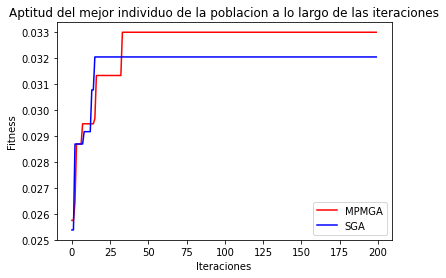

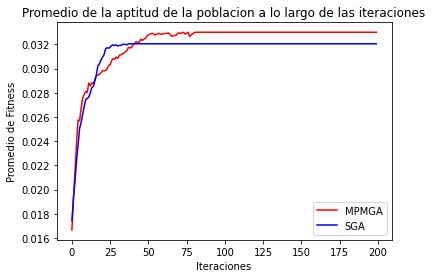

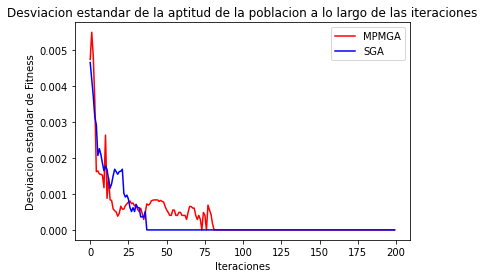

RESULTADO MPMGA
[(10, 11, 12, 13, 13, 13, 13, 13, 14, 15, 16, 17, 18, 19, 20, 20, 20, 20, 20, 20, 20, 20, 21, 22, 23, 24), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24)]


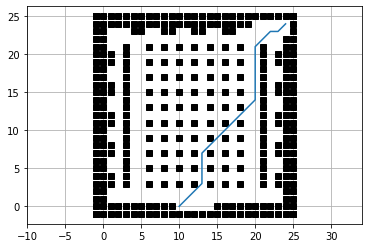

Path:  30.384776310850242
Smoothness:  30.0
fitnes Total:  0.032995641144399596
RESULTADO SGA
[(10, 10, 10, 11, 12, 13, 13, 13, 13, 13, 13, 13, 14, 15, 16, 17, 18, 19, 19, 19, 19, 20, 21, 22, 23, 24), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 22, 23, 24)]


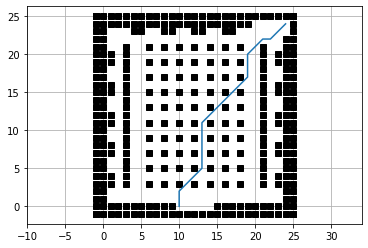

Path:  30.384776310850242
Smoothness:  35.0
fitnes Total:  0.03204326019201864


In [182]:
experimento(mapa2,[25,25],[10,numero_de(24,24,25)])

Tiempo de generacion de poblacion inicial
0:00:01.854366
inicio MPMGA----------------------------
Tiempo de MPMGA
0:00:22.584882
final MPMGA----------------------------
inicio estandar----------------------------
Tiempo de SGA
0:00:07.126603


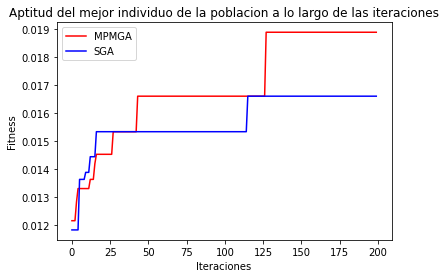

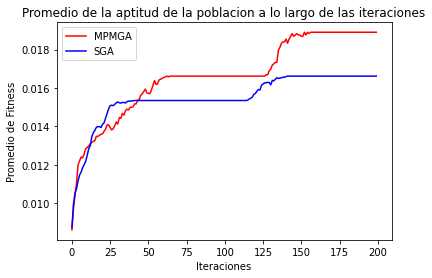

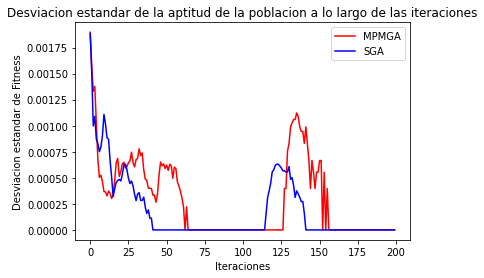

RESULTADO MPMGA
[(0, 0, 0, 1, 2, 3, 3, 3, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47, 47, 47, 47, 47, 47, 47, 48, 49)]


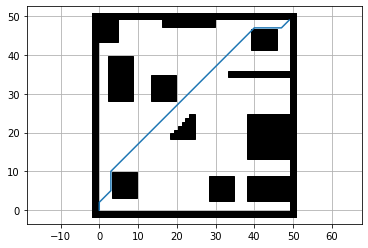

Path:  73.39696961966993
Smoothness:  25.0
fitnes Total:  0.018899632561745504
RESULTADO SGA
[(0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49)]


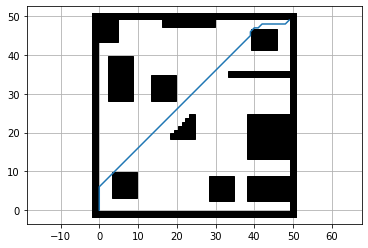

Path:  73.39696961966993
Smoothness:  35.0
fitnes Total:  0.01661391827603122


In [188]:
experimento(mapa3,[50,50],[0,2499])

In [185]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [186]:
!cat /proc/meminfo

MemTotal:       13302920 kB
MemFree:        10213480 kB
MemAvailable:   12056880 kB
Buffers:          123124 kB
Cached:          1784180 kB
SwapCached:            0 kB
Active:          1416332 kB
Inactive:        1448100 kB
Active(anon):     836624 kB
Inactive(anon):      456 kB
Active(file):     579708 kB
Inactive(file):  1447644 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               584 kB
Writeback:             0 kB
AnonPages:        957092 kB
Mapped:           270692 kB
Shmem:              1168 kB
KReclaimable:     115044 kB
Slab:             158824 kB
SReclaimable:     115044 kB
SUnreclaim:        43780 kB
KernelStack:        4784 kB
PageTables:        12944 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    3254164 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        7152 kB
VmallocChunk:          0 kB
Percpu:          

In [187]:
!python --version

Python 3.7.12
